In [22]:
import sys
import time
import pickle
import numpy as np
from tqdm import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
from pong.pongclass import pongGame

# Generate Data

In [12]:
def load_agent(file_name):
    # Load pickle file
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    data['grid_dem'] = 8 if data['grid_dem'] is None else data['grid_dem']
    returns = [data['Q'], data['map_size'], 
               data['grid_dem'], data['include_vel'],
               data['avg_score'], data['win_count'], data['iter_time'],
               data['alpha'], data['epsilon']]
    if 'train_time' in data:
        returns.append(data['train_time'])
        
    return tuple(returns)

def clear_line():
    """ Clears the last line in the terminal"""
    print("\033[A                             \033[A")

def tab(item, grid_dem, map_size) -> int:
        val = int(np.floor((item/map_size)*grid_dem))
        if val >= grid_dem:
            val = grid_dem-1
        return val

def tab_vel_x(vel: float) -> int:
    # return float(f"{vel:.1f}")
    # return int(vel)
    if vel < -2:
        return 0
    elif vel < 0:
        return 1
    elif vel < 2:
        return 2
    else:
        return 3

def tab_vel_y(vel: float) -> int:
    # return float(f"{vel:.1f}")
    # return int(vel)
    if vel < -1.5:
        return 0
    elif vel < -1.0:
        return 1
    elif vel < -0.5:
        return 2
    elif vel < 0:
        return 3
    elif vel < 0.5:
        return 4
    elif vel < 1.0:
        return 5
    elif vel < 1.5:
        return 6
    else:
        return 7
    

In [21]:
def get_data(file_names, last_file: str, iters=1000):
    GAME_SPEED = 2
    DRAW = False

    epochs = []
    total_wins_lst = []
    total_hits_lst = []
    total_scores_lst = []
    online_scores_lst = []
    online_wins_lst = []
    online_iter_times_lst = []
    last_file = "output/"+last_file+".pkl"
    full_time = load_agent(last_file)[-1]
    for file_name, epoch in tqdm(file_names):
        # --- Args Loading and Error Checking --- #
        load_path = "output/"+file_name+".pkl"
        try:
            (Q, map_size, grid_dem, 
             include_vel, online_score, 
             online_wins, online_iter_time, 
             alpha, epsilon) = load_agent(load_path)
            online_scores_lst.append(online_score)
            online_wins_lst.append(online_wins)
            online_iter_times_lst.append(online_iter_time)
        except Exception:
            continue
        # Start the game
        rewards = []
        total_hits = []
        total_wins = []
        player_vals = []
        ball_x_vals = []
        ball_y_vals = []
        vel_x_vals = []
        vel_y_vals = []
        for _ in range(iters):
            # Load Game
            p = pongGame(map_size, map_size, 
                        draw=DRAW, game_speed=GAME_SPEED)
            done = False
            hits = 0
            while not done:
                state = p.getState()[:6]
                player, c, ball_x, ball_y, vel_x, vel_y = state
                player_vals.append(player)
                ball_x_vals.append(ball_x)
                ball_y_vals.append(ball_y)
                vel_x_vals.append(vel_x)
                vel_y_vals.append(vel_y)
                player = tab(player, grid_dem, map_size)
                ball_x = tab(ball_x, grid_dem, map_size)
                ball_y = tab(ball_y, grid_dem, map_size)
                if include_vel:
                    vel_x = tab_vel_x(vel_x)
                    vel_y = tab_vel_y(vel_y)

                if isinstance(Q, np.ndarray):
                    if include_vel:
                        action_values = Q[player, ball_x, ball_y, vel_x, vel_y]
                    else:
                        action_values = Q[player, ball_x, ball_y]
                else:
                    x = np.array([player, c, ball_x, ball_y, vel_x, vel_y])
                    action_values = Q.predict(x=x.reshape(1, 6),
                                                verbose=0)[0][0]

                action = np.argmax(action_values)
                r = p.takeAction(action)
                if r == 1:
                    hits = hits+1
                if r == 100 or r == -100:
                    done = True
            rewards.append(r)
            total_hits.append(hits)
            total_wins.append(1 if r == 100 else 0)

        epochs.append(epoch)
        total_wins_lst.append(np.sum(total_wins))
        total_hits_lst.append(np.mean(total_hits))
        total_scores_lst.append(np.mean(rewards))
    returns = (epochs, total_wins_lst, total_hits_lst, total_scores_lst,
               online_scores_lst, online_wins_lst, online_iter_times_lst,
               alpha, epsilon, grid_dem, full_time)
    return returns


## No Velocity

In [39]:
file_names = [(f'qlearn_no_vel_{i}episodes', i) for i in range(100, 5001, 100)]
(no_vel_epochs, no_vel_total_wins_lst, 
 no_vel_total_hits_lst, no_vel_total_scores_lst, 
 no_vel_online_scores, no_vel_online_wins, 
 no_vel_online_iter_times,
 no_vel_alpha, no_vel_epsilon, 
 no_vel_grid_dem, no_vel_full_time) = get_data(file_names, 
                                               last_file='qlearn_no_vel_4999episodes',
                                               iters=500)

100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


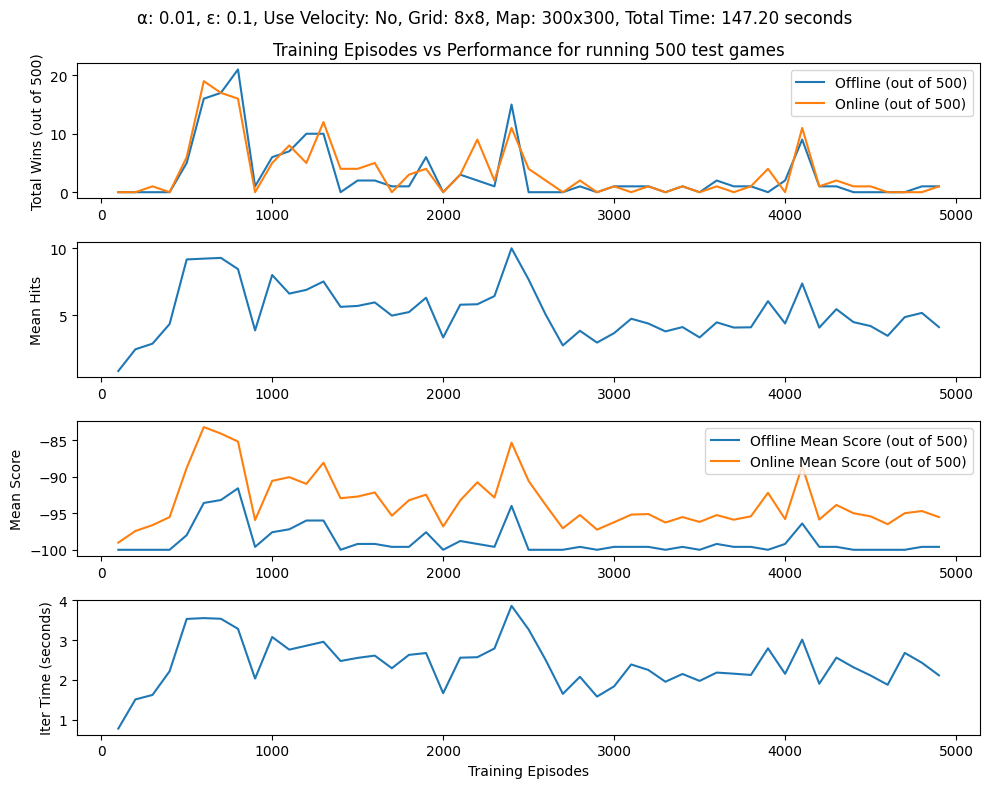

In [47]:
# Create a line plot figure usgin matplotlib
num_iters = 500
use_vel = 'No'
fig, ax = plt.subplots(figsize=(10, 8), nrows=4, ncols=1)
# Line plot
ax[0].plot(no_vel_epochs, no_vel_total_wins_lst, label=f'Offline (out of {num_iters})')
ax[0].plot(no_vel_epochs, no_vel_online_wins, label=f'Online (out of {num_iters})')
ax[1].plot(no_vel_epochs, no_vel_total_hits_lst, label=f'Offline Hits (out of {num_iters})')
ax[2].plot(no_vel_epochs, no_vel_total_scores_lst, label=f'Offline Mean Score (out of {num_iters})')
ax[2].plot(no_vel_epochs, no_vel_online_scores, label=f'Online Mean Score (out of {num_iters})')
ax[3].plot(no_vel_epochs, no_vel_online_iter_times, label=f'Online Iteration Time ({num_iters})')
ax[0].set_title(f'Training Episodes vs Performance for running {num_iters} test games')
ax[3].set_xlabel('Training Episodes')
ax[0].set_ylabel(f'Total Wins (out of {num_iters})')
ax[1].set_ylabel('Mean Hits')
ax[2].set_ylabel('Mean Score')
ax[3].set_ylabel('Iter Time (seconds)')
ax[0].legend()
ax[2].legend()
fig.suptitle(f"α: {no_vel_alpha}, ε: {no_vel_epsilon}, Use Velocity: {use_vel}, "\
             f"Grid: {no_vel_grid_dem}x{no_vel_grid_dem}, Map: 300x300, Total Time: {no_vel_full_time:.2f} seconds")
fig.tight_layout()


## Velocity: 4x 8y

In [41]:
file_names = [(f'qlearn_4x_8y_{i}episodes_with_vel', i) for i in range(100, 10001, 100)]
(vel_4x_8y_epochs, vel_4x_8y_total_wins_lst, 
 vel_4x_8y_total_hits_lst, vel_4x_8y_total_scores_lst,
 vel_4x_8y_online_scores, vel_4x_8y_online_wins, 
 vel_4x_8y_online_iter_times, vel_4x_8y_alpha, 
 vel_4x_8y_epsilon, vel_4x_8y_grid_dem, 
 vel_4x_8y_full_time) = get_data(file_names,
                                 last_file='qlearn_4x_8y_9999episodes_with_vel',
                                 iters=500)

100%|██████████| 50/50 [03:24<00:00,  4.08s/it]


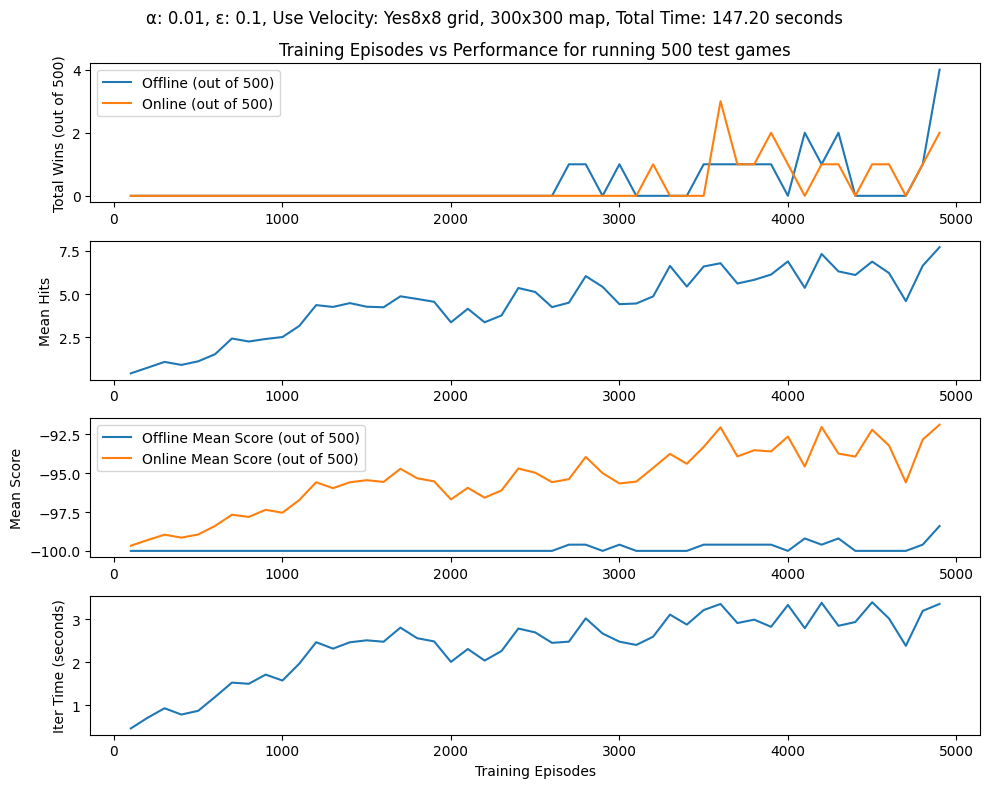

In [42]:
# Create a line plot figure usgin matplotlib
num_iters = 500
use_vel = 'Yes'
fig, ax = plt.subplots(figsize=(10, 8), nrows=4, ncols=1)
# Line plot
ax[0].plot(vel_4x_8y_epochs, vel_4x_8y_total_wins_lst, label=f'Offline (out of {num_iters})')
ax[0].plot(vel_4x_8y_epochs, vel_4x_8y_online_wins, label=f'Online (out of {num_iters})')
ax[1].plot(vel_4x_8y_epochs, vel_4x_8y_total_hits_lst, label=f'Offline Hits (out of {num_iters})')
ax[2].plot(vel_4x_8y_epochs, vel_4x_8y_total_scores_lst, label=f'Offline Mean Score (out of {num_iters})')
ax[2].plot(vel_4x_8y_epochs, vel_4x_8y_online_scores, label=f'Online Mean Score (out of {num_iters})')
ax[3].plot(vel_4x_8y_epochs, vel_4x_8y_online_iter_times, label=f'Online Iteration Time ({num_iters})')
ax[0].set_title(f'Training Episodes vs Performance for running {num_iters} test games')
ax[3].set_xlabel('Training Episodes')
ax[0].set_ylabel(f'Total Wins (out of {num_iters})')
ax[1].set_ylabel('Mean Hits')
ax[2].set_ylabel('Mean Score')
ax[3].set_ylabel('Iter Time (seconds)')
ax[0].legend()
ax[2].legend()
fig.suptitle(f"α: {no_vel_alpha}, ε: {no_vel_epsilon}, Use Velocity: {use_vel}, "\
             f"Grid: {no_vel_grid_dem}x{no_vel_grid_dem}, Map: 300x300, Total Time: {no_vel_full_time:.2f} seconds")
fig.tight_layout()


## Velocity: 4x 8y alpha: 0.05

In [43]:
file_names = [(f'qlearn_4x_8y_alpha0.05_{i}episodes_with_vel', i) for i in range(100, 5001, 100)]
(vel_4x_8y_epochs, vel_4x_8y_total_wins_lst, 
 vel_4x_8y_total_hits_lst, vel_4x_8y_total_scores_lst,
 vel_4x_8y_online_scores, vel_4x_8y_online_wins, 
 vel_4x_8y_online_iter_times, vel_4x_8y_alpha, 
 vel_4x_8y_epsilon, vel_4x_8y_grid_dem, 
 vel_4x_8y_full_time) = get_data(file_names,
                                 last_file='qlearn_4x_8y_alpha0.05_4999episodes_with_vel',
                                 iters=500)

100%|██████████| 50/50 [03:08<00:00,  3.76s/it]


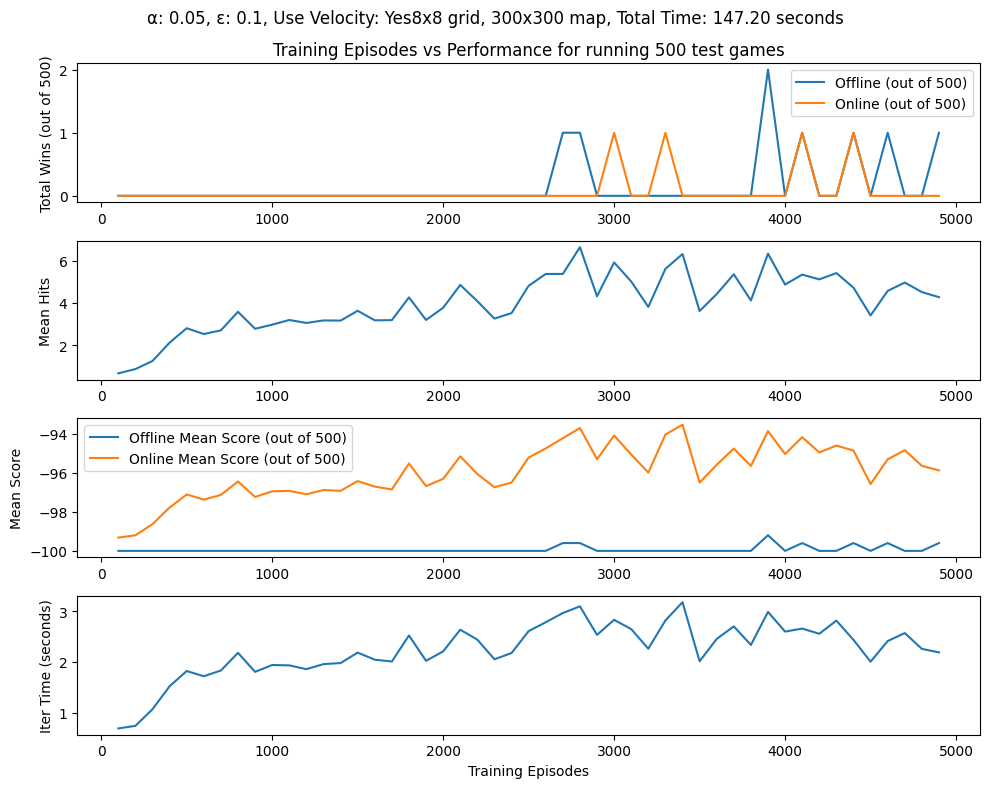

In [44]:
# Create a line plot figure usgin matplotlib
num_iters = 500
use_vel = 'Yes'
fig, ax = plt.subplots(figsize=(10, 8), nrows=4, ncols=1)
# Line plot
ax[0].plot(vel_4x_8y_epochs, vel_4x_8y_total_wins_lst, label=f'Offline (out of {num_iters})')
ax[0].plot(vel_4x_8y_epochs, vel_4x_8y_online_wins, label=f'Online (out of {num_iters})')
ax[1].plot(vel_4x_8y_epochs, vel_4x_8y_total_hits_lst, label=f'Offline Hits (out of {num_iters})')
ax[2].plot(vel_4x_8y_epochs, vel_4x_8y_total_scores_lst, label=f'Offline Mean Score (out of {num_iters})')
ax[2].plot(vel_4x_8y_epochs, vel_4x_8y_online_scores, label=f'Online Mean Score (out of {num_iters})')
ax[3].plot(vel_4x_8y_epochs, vel_4x_8y_online_iter_times, label=f'Online Iteration Time ({num_iters})')
ax[0].set_title(f'Training Episodes vs Performance for running {num_iters} test games')
ax[3].set_xlabel('Training Episodes')
ax[0].set_ylabel(f'Total Wins (out of {num_iters})')
ax[1].set_ylabel('Mean Hits')
ax[2].set_ylabel('Mean Score')
ax[3].set_ylabel('Iter Time (seconds)')
ax[0].legend()
ax[2].legend()
fig.suptitle(f"α: {no_vel_alpha}, ε: {no_vel_epsilon}, Use Velocity: {use_vel}, "\
             f"Grid: {no_vel_grid_dem}x{no_vel_grid_dem}, Map: 300x300, Total Time: {no_vel_full_time:.2f} seconds")
fig.tight_layout()


## Velocity: 4x 8y epsilon: 0.2

In [45]:
file_names = [(f'qlearn_4x_8y_eps0.2_{i}episodes_with_vel', i) for i in range(100, 5001, 100)]
(vel_4x_8y_epochs, vel_4x_8y_total_wins_lst, 
 vel_4x_8y_total_hits_lst, vel_4x_8y_total_scores_lst,
 vel_4x_8y_online_scores, vel_4x_8y_online_wins, 
 vel_4x_8y_online_iter_times, vel_4x_8y_alpha, 
 vel_4x_8y_epsilon, vel_4x_8y_grid_dem, 
 vel_4x_8y_full_time) = get_data(file_names,
                                 last_file='qlearn_4x_8y_eps0.2_4999episodes_with_vel',
                                 iters=500)

100%|██████████| 50/50 [03:18<00:00,  3.98s/it]


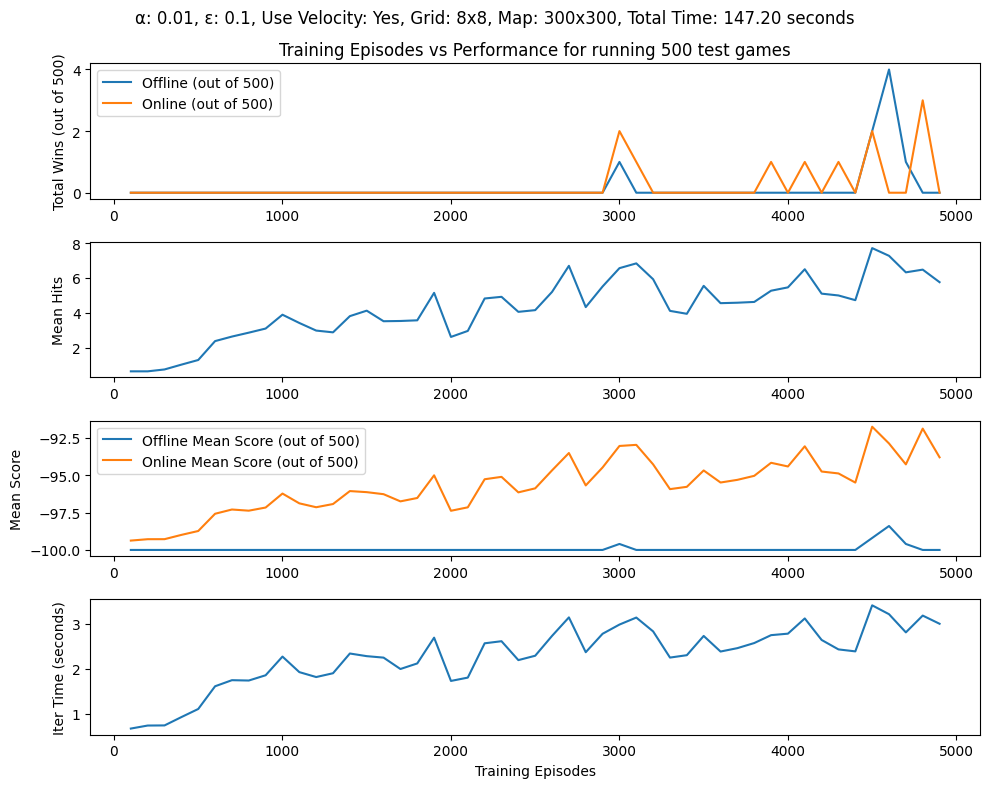

In [46]:
# Create a line plot figure usgin matplotlib
num_iters = 500
use_vel = 'Yes'
fig, ax = plt.subplots(figsize=(10, 8), nrows=4, ncols=1)
# Line plot
ax[0].plot(vel_4x_8y_epochs, vel_4x_8y_total_wins_lst, label=f'Offline (out of {num_iters})')
ax[0].plot(vel_4x_8y_epochs, vel_4x_8y_online_wins, label=f'Online (out of {num_iters})')
ax[1].plot(vel_4x_8y_epochs, vel_4x_8y_total_hits_lst, label=f'Offline Hits (out of {num_iters})')
ax[2].plot(vel_4x_8y_epochs, vel_4x_8y_total_scores_lst, label=f'Offline Mean Score (out of {num_iters})')
ax[2].plot(vel_4x_8y_epochs, vel_4x_8y_online_scores, label=f'Online Mean Score (out of {num_iters})')
ax[3].plot(vel_4x_8y_epochs, vel_4x_8y_online_iter_times, label=f'Online Iteration Time ({num_iters})')
ax[0].set_title(f'Training Episodes vs Performance for running {num_iters} test games')
ax[3].set_xlabel('Training Episodes')
ax[0].set_ylabel(f'Total Wins (out of {num_iters})')
ax[1].set_ylabel('Mean Hits')
ax[2].set_ylabel('Mean Score')
ax[3].set_ylabel('Iter Time (seconds)')
ax[0].legend()
ax[2].legend()
fig.suptitle(f"α: {no_vel_alpha}, ε: {no_vel_epsilon}, Use Velocity: {use_vel}, "\
             f"Grid: {no_vel_grid_dem}x{no_vel_grid_dem}, Map: 300x300, Total Time: {no_vel_full_time:.2f} seconds")
fig.tight_layout()
